In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from keras.losses import MeanSquaredLogarithmicError
from keras.models import load_model

Mounted at /content/drive


# 100m only 10x10



In [2]:
df_100m = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_100_10.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})
# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df_100m

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Descriptors 0,...,Descriptors 503,Descriptors 504,Descriptors 505,Descriptors 506,Descriptors 507,Descriptors 508,Descriptors 509,Descriptors 510,Descriptors 511,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2,0.0,0.0,0.0,0.0,3.271589,2.763679,3.271589,2.763679,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,37.46
622,2,0.0,0.0,0.0,0.0,0.000000,0.000000,4.289013,4.260633,0.0,...,4.0,6.0,17.0,1.0,7.0,5.0,0.0,0.0,0.0,37.46
623,2,0.0,0.0,0.0,0.0,6.650951,3.949461,6.650951,3.949461,0.0,...,3.0,7.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,37.46
624,2,0.0,0.0,0.0,0.0,0.000000,0.000000,2.470051,7.089897,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22


In [3]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df_100m[df_100m['Feature Extraction 0'].isna()]
nan_rows_d = df_100m[df_100m['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df_100m = df_100m.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df_100m = df_100m.dropna(subset=['Descriptors 0'])

Found 313 rows with NaN values in the Feature Extraction column.
Found 313 rows with NaN values in the Descriptors column.


In [4]:
X_100m_10 = df_100m.drop('Carbon Values', axis=1)
y_100m_10 = df_100m['Carbon Values']

In [5]:
X_train_100_10, X_test_100_10, y_train_100_10, y_test_100_10 = train_test_split(X_100m_10, y_100m_10, test_size=0.2, random_state=42)

In [6]:
X_train_100_10 = X_train_100_10.values.reshape((X_train_100_10.shape[0], X_train_100_10.shape[1], 1))
X_test_100_10 = X_test_100_10.values.reshape((X_test_100_10.shape[0], X_test_100_10.shape[1], 1))

y_train_100_10 = y_train_100_10.values
y_test_100_10 = y_test_100_10.values



In [7]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train_100_10, X_test_100_10])

# Flatten the input sequences
X_train_flattened_100_10 = np.array([x.flatten() for x in X_train_100_10])
X_test_flattened_100_10 = np.array([x.flatten() for x in X_test_100_10])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized_100_10 = scaler.fit_transform(X_train_flattened_100_10)
X_test_normalized_100_10 = scaler.transform(X_test_flattened_100_10)

# Reshape the paddedsequences to match the input shape expected by the model
X_train_padded_100_10 = np.expand_dims(X_train_normalized_100_10, axis=-1)
X_test_padded_100_10 = np.expand_dims(X_test_normalized_100_10, axis=-1)


In [8]:
from keras.models import Model
from keras.layers import Flatten,Input,InputLayer, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=512, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1,activation='relu')(x)

model_100_10 = Model(inputs=inputs, outputs=outputs)


In [9]:
model_100_10.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

In [10]:
hist_100_10 = model_100_10.fit(X_train_padded_100_10, y_train_100_10,
                            epochs= 300,
                            batch_size=64,
                            verbose = 1,
                            callbacks=[reduce_lr,early_stop],
                               validation_data=(X_test_padded_100_10, y_test_100_10))

Epoch 1/300
4/4 [==============================] - 11s 220ms/step - loss: 67.9514 - val_loss: 94.4850 - lr: 0.0010
Epoch 2/300
4/4 [==============================] - 0s 23ms/step - loss: 48.0649 - val_loss: 95.9695 - lr: 0.0010
Epoch 3/300
4/4 [==============================] - 0s 22ms/step - loss: 36.2596 - val_loss: 96.4035 - lr: 0.0010
Epoch 4/300
4/4 [==============================] - 0s 24ms/step - loss: 38.9180 - val_loss: 95.1432 - lr: 0.0010
Epoch 5/300
4/4 [==============================] - 0s 22ms/step - loss: 37.2921 - val_loss: 95.2638 - lr: 0.0010
Epoch 6/300
4/4 [==============================] - 0s 22ms/step - loss: 36.7114 - val_loss: 96.2215 - lr: 0.0010
Epoch 7/300
4/4 [==============================] - 0s 24ms/step - loss: 35.7924 - val_loss: 95.1912 - lr: 0.0010
Epoch 8/300
4/4 [==============================] - 0s 23ms/step - loss: 38.2446 - val_loss: 94.9066 - lr: 0.0010
Epoch 9/300
4/4 [==============================] - 0s 22ms/step - loss: 36.1184 - val_loss: 95

In [11]:
y_pred_100_10 = model_100_10.predict(X_test_padded_100_10)
mape = mean_absolute_percentage_error(y_test_100_10, y_pred_100_10)
print(f'MAPE: {mape}')

2/2 [==============================] - 0s 114ms/step
MAPE: 0.19968665695609933


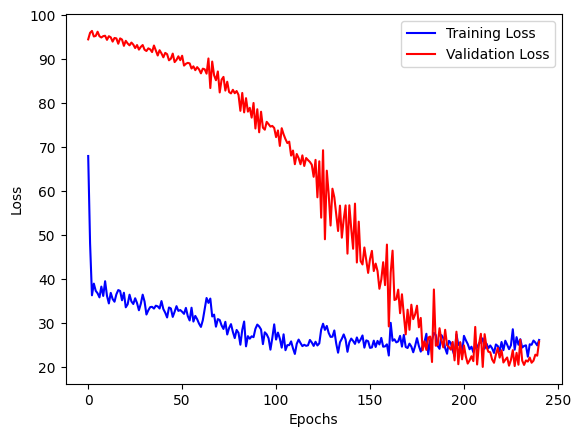

In [12]:
import matplotlib.pyplot as plt


plt.plot(hist_100_10.history['loss'], label='Training Loss', color='blue')
plt.plot(hist_100_10.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test_100_10, y_pred_100_10)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_100_10, y_pred_100_10)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_100_10, y_pred_100_10, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared score on test set: 0.2905695313423128
Mean Absolute Error (MAE): 5.402530926901196
Root Mean Squared Error (RMSE): 6.987890221991452


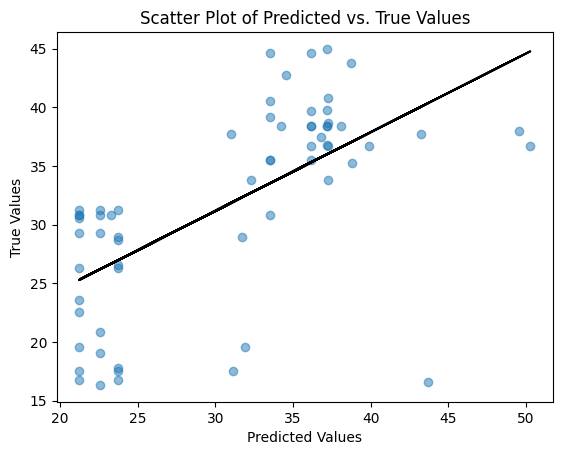

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred_100_10, y_test_100_10, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred_100_10.flatten(), y_test_100_10.flatten(), 1)
plt.plot(y_pred_100_10.flatten(), m*y_pred_100_10.flatten() + b, color='black')

plt.show()



In [15]:
X_train_100_10, X_test_100_10, y_train_100_10, y_test_100_10 = train_test_split(X_100m_10, y_100m_10, test_size=0.2, random_state=42)

In [16]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_100_10)
X_test_scaled = scaler.transform(X_test_100_10)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=1)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train_100_10)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test_100_10)
print("Model score:", score)


[LibSVM]Model score: 0.5886571432638565


In [17]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test_100_10, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_100_10, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_100_10, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_100_10, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.5886571432638565
Mean Absolute Error (MAE): 4.177771986083208
Root Mean Squared Error (RMSE): 5.320998485629889
Mean Absolute Percentage Error (MAPE): 0.16347867661683577


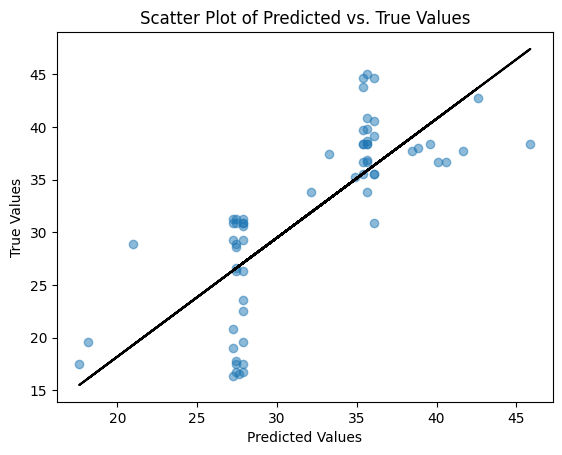

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_100_10, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_100_10, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [19]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_100_10)
X_test_scaled = scaler.transform(X_test_100_10)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train_100_10)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test_100_10, y_pred)
print("Model score:", score)


Model score: 0.6378812295029697


In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test_100_10, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_100_10, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_100_10, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_100_10, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.6378812295029697
Mean Absolute Error (MAE): 4.143080698855056
Root Mean Squared Error (RMSE): 4.992483910869381
Mean Absolute Percentage Error (MAPE): 0.1484742846490002


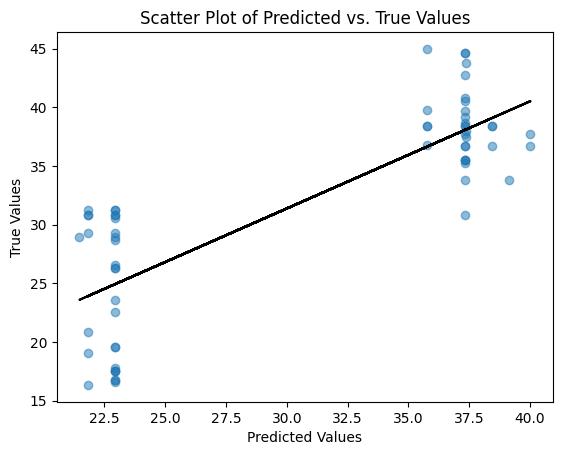

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_100_10, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_100_10, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# 100m only 20x20



In [22]:
df_100m_20 = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_100_20.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df_100m_20

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 2167,Descriptors 2168,Descriptors 2169,Descriptors 2170,Descriptors 2171,Descriptors 2172,Descriptors 2173,Descriptors 2174,Descriptors 2175,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26.0,9.0,35.0,52.0,34.0,26.0,4.0,5.0,8.0,41.22
1064,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.0,33.0,95.0,132.0,32.0,1.0,2.0,6.0,15.0,41.22
1065,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,42.0,64.0,4.0,0.0,0.0,41.22
1066,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,18.0,15.0,7.0,9.0,0.0,0.0,41.22


In [23]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df_100m_20[df_100m_20['Feature Extraction 0'].isna()]
nan_rows_d = df_100m_20[df_100m_20['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df_100m_20 = df_100m_20.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df_100m_20 = df_100m_20.dropna(subset=['Descriptors 0'])

Found 534 rows with NaN values in the Feature Extraction column.
Found 534 rows with NaN values in the Descriptors column.


In [24]:
X_100m_20 = df_100m_20.drop('Carbon Values', axis=1)
y_100m_20 = df_100m_20['Carbon Values']

In [25]:
X_train_100_20, X_test_100_20, y_train_100_20, y_test_100_20 = train_test_split(X_100m_20, y_100m_20, test_size=0.2, random_state=42)

In [26]:
X_train_100_20 = X_train_100_20.values.reshape((X_train_100_20.shape[0], X_train_100_20.shape[1], 1))
X_test_100_20 = X_test_100_20.values.reshape((X_test_100_20.shape[0], X_test_100_20.shape[1], 1))

y_train_100_20 = y_train_100_20.values
y_test_100_20 = y_test_100_20.values

In [27]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train_100_20, X_test_100_20])

# Flatten the input sequences
X_train_flattened_100_20 = np.array([x.flatten() for x in X_train_100_20])
X_test_flattened_100_20 = np.array([x.flatten() for x in X_test_100_20])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized_100_20 = scaler.fit_transform(X_train_flattened_100_20)
X_test_normalized_100_20 = scaler.transform(X_test_flattened_100_20)

# Reshape the paddedsequences to match the input shape expected by the model
X_train_padded_100_20 = np.expand_dims(X_train_normalized_100_20, axis=-1)
X_test_padded_100_20 = np.expand_dims(X_test_normalized_100_20, axis=-1)


In [28]:
from keras.models import Model
from keras.layers import Flatten,Input,InputLayer, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=512, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1,activation='relu')(x)

model_100_20 = Model(inputs=inputs, outputs=outputs)


In [29]:
model_100_20.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

In [30]:
hist_100_20 = model_100_20.fit(X_train_padded_100_20, y_train_100_20,
                               epochs= 300,
                               batch_size=64,
                               verbose = 1,
                               callbacks=[reduce_lr,early_stop],
                               validation_data=(X_test_padded_100_20, y_test_100_20))

Epoch 1/300
7/7 [==============================] - 5s 186ms/step - loss: 64.5156 - val_loss: 94.1130 - lr: 0.0010
Epoch 2/300
7/7 [==============================] - 0s 68ms/step - loss: 42.2991 - val_loss: 95.0847 - lr: 0.0010
Epoch 3/300
7/7 [==============================] - 0s 68ms/step - loss: 37.5844 - val_loss: 94.8837 - lr: 0.0010
Epoch 4/300
7/7 [==============================] - 0s 69ms/step - loss: 37.9207 - val_loss: 94.7269 - lr: 0.0010
Epoch 5/300
7/7 [==============================] - 0s 63ms/step - loss: 36.1562 - val_loss: 94.7805 - lr: 0.0010
Epoch 6/300
7/7 [==============================] - 0s 63ms/step - loss: 37.0079 - val_loss: 94.5483 - lr: 0.0010
Epoch 7/300
7/7 [==============================] - 0s 68ms/step - loss: 36.6332 - val_loss: 94.4038 - lr: 0.0010
Epoch 8/300
7/7 [==============================] - 0s 68ms/step - loss: 36.1170 - val_loss: 94.1157 - lr: 0.0010
Epoch 9/300
7/7 [==============================] - 0s 69ms/step - loss: 35.2433 - val_loss: 93.

In [31]:
y_pred_100_20 = model_100_20.predict(X_test_padded_100_20)
mape = mean_absolute_percentage_error(y_test_100_20, y_pred_100_20)
print(f'MAPE: {mape}')

4/4 [==============================] - 1s 54ms/step
MAPE: 0.26276301052676193


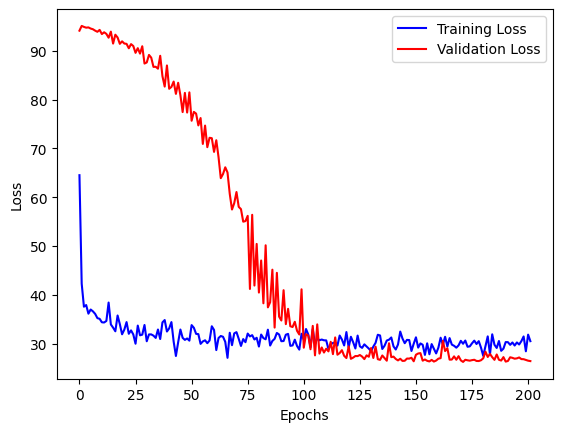

In [32]:
import matplotlib.pyplot as plt


plt.plot(hist_100_20.history['loss'], label='Training Loss', color='blue')
plt.plot(hist_100_20.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test_100_20, y_pred_100_20)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_100_20, y_pred_100_20)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_100_20, y_pred_100_20, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared score on test set: -0.14986079557470755
Mean Absolute Error (MAE): 7.494727367508077
Root Mean Squared Error (RMSE): 9.566671980355236


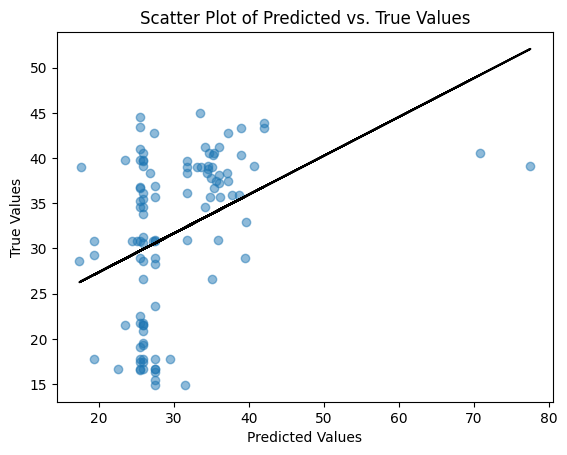

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred_100_20, y_test_100_20, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred_100_20.flatten(), y_test_100_20.flatten(), 1)
plt.plot(y_pred_100_20.flatten(), m*y_pred_100_20.flatten() + b, color='black')

plt.show()


In [35]:
X_train_100_20, X_test_100_20, y_train_100_20, y_test_100_20 = train_test_split(X_100m_20, y_100m_20, test_size=0.2, random_state=42)

In [36]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_100_20)
X_test_scaled = scaler.transform(X_test_100_20)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train_100_20)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test_100_20)
print("Model score:", score)


[LibSVM]Model score: 0.5711512224260595


In [37]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test_100_20, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_100_20, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_100_20, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_100_20, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.5711512224260595
Mean Absolute Error (MAE): 4.608540312388245
Root Mean Squared Error (RMSE): 5.842387224660849
Mean Absolute Percentage Error (MAPE): 0.18866951354891917


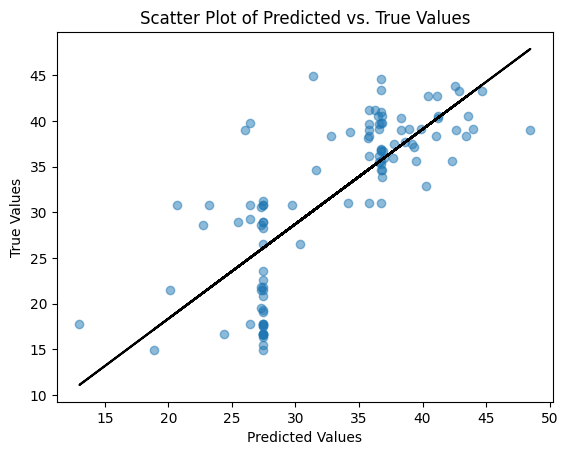

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_100_20, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_100_20, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [39]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_100_20)
X_test_scaled = scaler.transform(X_test_100_20)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train_100_20)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test_100_20, y_pred)
print("Model score:", score)


Model score: 0.7523635004854965


In [40]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test_100_20, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_100_20, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_100_20, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_100_20, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.7523635004854965
Mean Absolute Error (MAE): 3.673842541835277
Root Mean Squared Error (RMSE): 4.4396177383372
Mean Absolute Percentage Error (MAPE): 0.14171361711812877


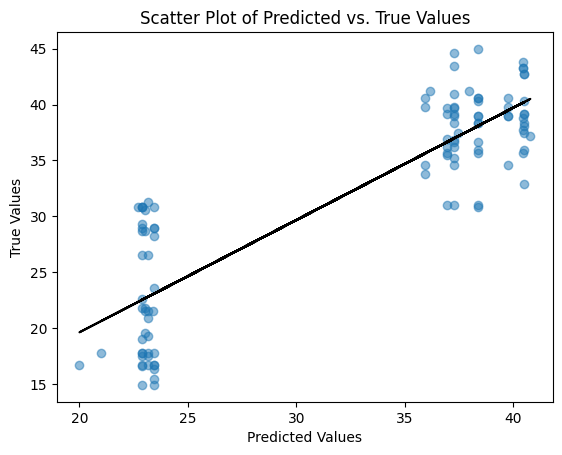

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_100_20, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_100_20, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# 100m only 30x30



In [42]:
df_100m_30 = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_100_30.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df_100m_30

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 5111,Descriptors 5112,Descriptors 5113,Descriptors 5114,Descriptors 5115,Descriptors 5116,Descriptors 5117,Descriptors 5118,Descriptors 5119,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,31.0,32.0,1.0,1.0,5.0,2.0,0.0,0.0,41.22
1076,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,9.0,7.0,6.0,0.0,0.0,0.0,41.22
1077,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,41.22
1078,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22


In [43]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df_100m_30[df_100m_30['Feature Extraction 0'].isna()]
nan_rows_d = df_100m_30[df_100m_30['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df_100m_30 = df_100m_30.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df_100m_30 = df_100m_30.dropna(subset=['Descriptors 0'])

Found 540 rows with NaN values in the Feature Extraction column.
Found 540 rows with NaN values in the Descriptors column.


In [44]:
X_100m_30 = df_100m_30.drop('Carbon Values', axis=1)
y_100m_30 = df_100m_30['Carbon Values']

In [45]:
X_train_100_30, X_test_100_30, y_train_100_30, y_test_100_30 = train_test_split(X_100m_30, y_100m_30, test_size=0.2, random_state=42)

In [46]:
X_train_100_30 = X_train_100_30.values.reshape((X_train_100_30.shape[0], X_train_100_30.shape[1], 1))
X_test_100_30 = X_test_100_30.values.reshape((X_test_100_30.shape[0], X_test_100_30.shape[1], 1))

y_train_100_30 = y_train_100_30.values
y_test_100_30 = y_test_100_30.values

In [47]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train_100_30, X_test_100_30])

# Flatten the input sequences
X_train_flattened_100_30 = np.array([x.flatten() for x in X_train_100_30])
X_test_flattened_100_30 = np.array([x.flatten() for x in X_test_100_30])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized_100_30 = scaler.fit_transform(X_train_flattened_100_30)
X_test_normalized_100_30 = scaler.transform(X_test_flattened_100_30)

# Reshape the paddedsequences to match the input shape expected by the model
X_train_padded_100_30 = np.expand_dims(X_train_normalized_100_30, axis=-1)
X_test_padded_100_30 = np.expand_dims(X_test_normalized_100_30, axis=-1)


In [48]:
from keras.models import Model
from keras.layers import Flatten,Input,InputLayer, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=128, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=512, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1,activation='relu')(x)

model_100_30 = Model(inputs=inputs, outputs=outputs)


In [49]:
model_100_30.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

In [50]:
hist_100_30 = model_100_30.fit(X_train_padded_100_30, y_train_100_30,
                            epochs= 300,
                            batch_size=64,
                            verbose = 1,
                            callbacks=[reduce_lr,early_stop],
                               validation_data=(X_test_padded_100_30, y_test_100_30))

Epoch 1/300
7/7 [==============================] - 7s 588ms/step - loss: 66.3685 - val_loss: 95.3004 - lr: 0.0010
Epoch 2/300
7/7 [==============================] - 1s 151ms/step - loss: 43.3867 - val_loss: 96.4234 - lr: 0.0010
Epoch 3/300
7/7 [==============================] - 1s 152ms/step - loss: 40.7846 - val_loss: 96.0047 - lr: 0.0010
Epoch 4/300
7/7 [==============================] - 1s 152ms/step - loss: 39.4281 - val_loss: 96.1725 - lr: 0.0010
Epoch 5/300
7/7 [==============================] - 1s 149ms/step - loss: 39.7314 - val_loss: 96.1686 - lr: 0.0010
Epoch 6/300
7/7 [==============================] - 1s 160ms/step - loss: 34.9043 - val_loss: 95.7838 - lr: 0.0010
Epoch 7/300
7/7 [==============================] - 1s 160ms/step - loss: 37.8330 - val_loss: 96.1889 - lr: 0.0010
Epoch 8/300
7/7 [==============================] - 1s 161ms/step - loss: 32.4859 - val_loss: 95.5297 - lr: 0.0010
Epoch 9/300
7/7 [==============================] - 1s 162ms/step - loss: 35.2063 - val_l

In [51]:
y_pred_100_30 = model_100_30.predict(X_test_padded_100_30)
mape = mean_absolute_percentage_error(y_test_100_30, y_pred_100_30)
print(f'MAPE: {mape}')

4/4 [==============================] - 1s 81ms/step
MAPE: 0.7242605561903273


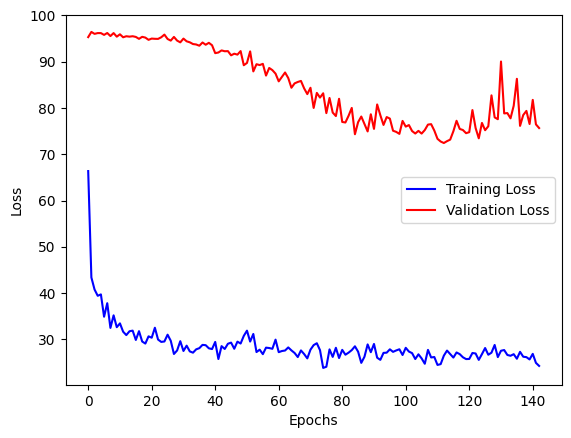

In [52]:
import matplotlib.pyplot as plt


plt.plot(hist_100_30.history['loss'], label='Training Loss', color='blue')
plt.plot(hist_100_30.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test_100_30, y_pred_100_30)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_100_30, y_pred_100_30)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_100_30, y_pred_100_30, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared score on test set: -440.71016087753935
Mean Absolute Error (MAE): 26.922652302494754
Root Mean Squared Error (RMSE): 197.50445654961274


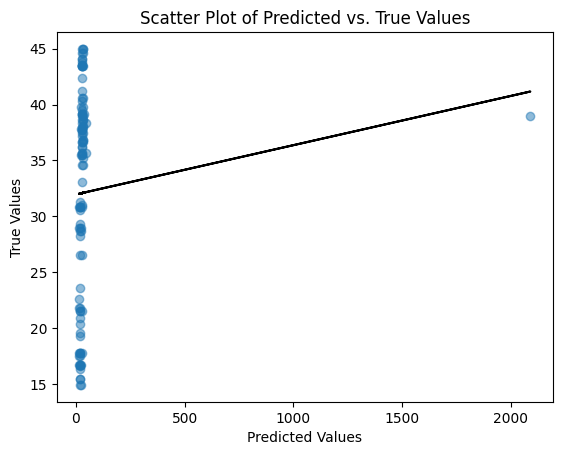

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred_100_30, y_test_100_30, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred_100_30.flatten(), y_test_100_30.flatten(), 1)
plt.plot(y_pred_100_30.flatten(), m*y_pred_100_30.flatten() + b, color='black')

plt.show()


In [55]:
X_train_100_30, X_test_100_30, y_train_100_30, y_test_100_30 = train_test_split(X_100m_30, y_100m_30, test_size=0.2, random_state=42)

In [56]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_100_30)
X_test_scaled = scaler.transform(X_test_100_30)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train_100_30)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test_100_30)
print("Model score:", score)


[LibSVM]Model score: 0.4926569859951344


In [57]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test_100_30, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_100_30, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_100_30, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_100_30, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.4926569859951344
Mean Absolute Error (MAE): 5.147845305763469
Root Mean Squared Error (RMSE): 6.693589074378595
Mean Absolute Percentage Error (MAPE): 0.19372125259180314


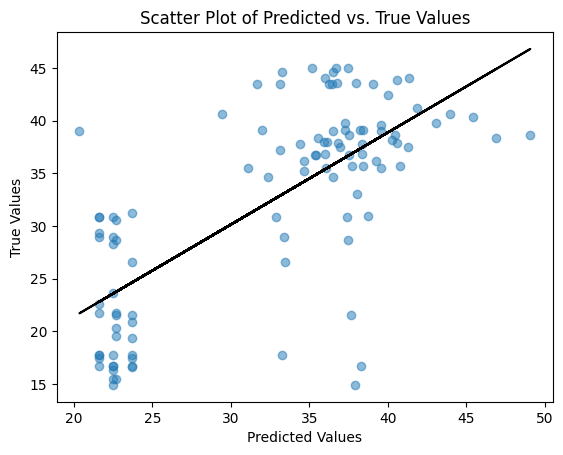

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_100_30, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_100_30, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [59]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_100_30)
X_test_scaled = scaler.transform(X_test_100_30)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train_100_30)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test_100_30, y_pred)
print("Model score:", score)


Model score: 0.7643188886457498


In [60]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test_100_30, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_100_30, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_100_30, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_100_30, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.7643188886457498
Mean Absolute Error (MAE): 3.852102344413179
Root Mean Squared Error (RMSE): 4.562160851989725
Mean Absolute Percentage Error (MAPE): 0.1493085273068573


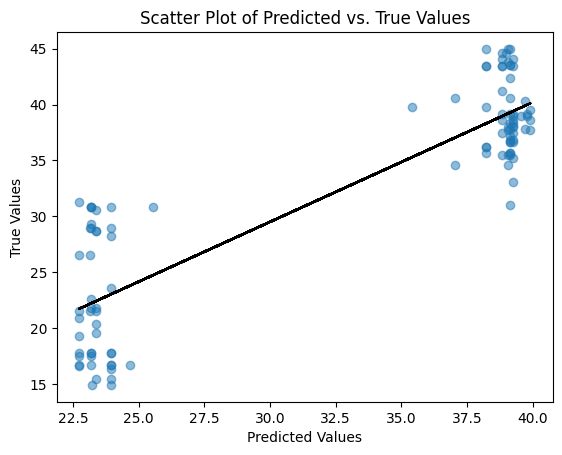

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_100_30, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_100_30, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# 50m only 10x10



In [62]:
df_50m = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_50_10.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df_50m

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Descriptors 0,...,Descriptors 503,Descriptors 504,Descriptors 505,Descriptors 506,Descriptors 507,Descriptors 508,Descriptors 509,Descriptors 510,Descriptors 511,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,2,0.0,0.0,0.0,0.0,0.0,0.0,5.596545,4.765850,0.0,...,10.0,0.0,0.0,0.0,2.0,3.0,9.0,36.0,4.0,39.54
554,2,0.0,0.0,0.0,0.0,0.0,0.0,3.543460,3.386272,0.0,...,1.0,10.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,39.15
555,2,0.0,0.0,0.0,0.0,0.0,0.0,3.506107,2.771296,0.0,...,9.0,11.0,76.0,20.0,2.0,0.0,1.0,0.0,0.0,39.15
556,2,0.0,0.0,0.0,0.0,0.0,0.0,3.054260,3.867163,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.46


In [63]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df_50m[df_50m['Feature Extraction 0'].isna()]
nan_rows_d = df_50m[df_50m['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df_50m = df_50m.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df_50m = df_50m.dropna(subset=['Descriptors 0'])

Found 279 rows with NaN values in the Feature Extraction column.
Found 279 rows with NaN values in the Descriptors column.


In [64]:
X_50_10 = df_50m.drop('Carbon Values', axis=1)
y_50_10 = df_50m['Carbon Values']

In [65]:
X_train_50_10, X_test_50_10, y_train_50_10, y_test_50_10 = train_test_split(X_50_10, y_50_10, test_size=0.2, random_state=42)

In [66]:
X_train_50_10 = X_train_50_10.values.reshape((X_train_50_10.shape[0], X_train_50_10.shape[1], 1))
X_test_50_10 = X_test_50_10.values.reshape((X_test_50_10.shape[0], X_test_50_10.shape[1], 1))

y_train_50_10 = y_train_50_10.values
y_test_50_10 = y_test_50_10.values

In [67]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train_50_10, X_test_50_10])

# Flatten the input sequences
X_train_flattened_50_10 = np.array([x.flatten() for x in X_train_50_10])
X_test_flattened_50_10 = np.array([x.flatten() for x in X_test_50_10])

# Normalize the flattened sequences
scaler = MaxAbsScaler()

X_train_normalized_50_10 = scaler.fit_transform(X_train_flattened_50_10)
X_test_normalized_50_10 = scaler.transform(X_test_flattened_50_10)


# Reshape the paddedsequences to match the input shape expected by the model
X_train_padded_50_10 = np.expand_dims(X_train_normalized_50_10, axis=-1)
X_test_padded_50_10 = np.expand_dims(X_test_normalized_50_10, axis=-1)


In [68]:
from keras.models import Model
from keras.layers import Flatten,Input,InputLayer, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))


x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=512, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1,activation='relu')(x)

model_50_10 = Model(inputs=inputs, outputs=outputs)


In [69]:
model_50_10.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

In [70]:
hist_50_10 = model_50_10.fit(X_train_padded_50_10, y_train_50_10,
                             epochs= 300,
                             batch_size=64,
                             verbose = 1,
                             callbacks=[reduce_lr, early_stop],
                             validation_data=(X_test_padded_50_10, y_test_50_10))

Epoch 1/300
4/4 [==============================] - 3s 183ms/step - loss: 79.4565 - val_loss: 95.4700 - lr: 0.0010
Epoch 2/300
4/4 [==============================] - 0s 17ms/step - loss: 46.4949 - val_loss: 91.9539 - lr: 0.0010
Epoch 3/300
4/4 [==============================] - 0s 15ms/step - loss: 49.9318 - val_loss: 93.5468 - lr: 0.0010
Epoch 4/300
4/4 [==============================] - 0s 15ms/step - loss: 45.2467 - val_loss: 95.1790 - lr: 0.0010
Epoch 5/300
4/4 [==============================] - 0s 15ms/step - loss: 44.6450 - val_loss: 94.3384 - lr: 0.0010
Epoch 6/300
4/4 [==============================] - 0s 15ms/step - loss: 42.0637 - val_loss: 92.8979 - lr: 0.0010
Epoch 7/300
4/4 [==============================] - 0s 21ms/step - loss: 41.1293 - val_loss: 92.8073 - lr: 0.0010
Epoch 8/300
4/4 [==============================] - 0s 18ms/step - loss: 40.6349 - val_loss: 93.1994 - lr: 0.0010
Epoch 9/300
4/4 [==============================] - 0s 17ms/step - loss: 37.2085 - val_loss: 93.

In [71]:
y_pred_50_10 = model_50_10.predict(X_test_padded_50_10)
mape = mean_absolute_percentage_error(y_test_50_10, y_pred_50_10)
print(f'MAPE: {mape}')

2/2 [==============================] - 0s 121ms/step
MAPE: 0.17202770652949592


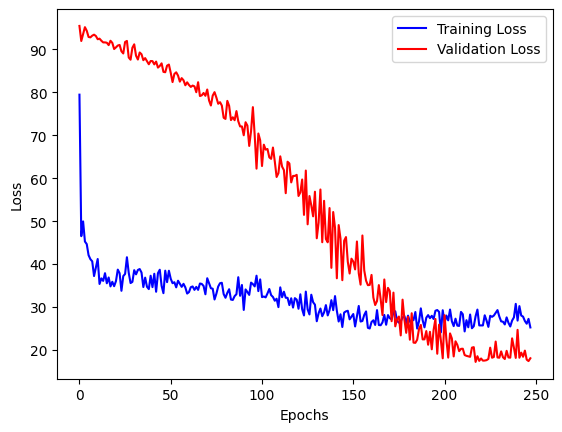

In [72]:
import matplotlib.pyplot as plt


plt.plot(hist_50_10.history['loss'], label='Training Loss', color='blue')
plt.plot(hist_50_10.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test_50_10, y_pred_50_10)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_50_10, y_pred_50_10)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_50_10, y_pred_50_10, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared score on test set: 0.39855677000836987
Mean Absolute Error (MAE): 5.03146779196603
Root Mean Squared Error (RMSE): 6.607292248970876


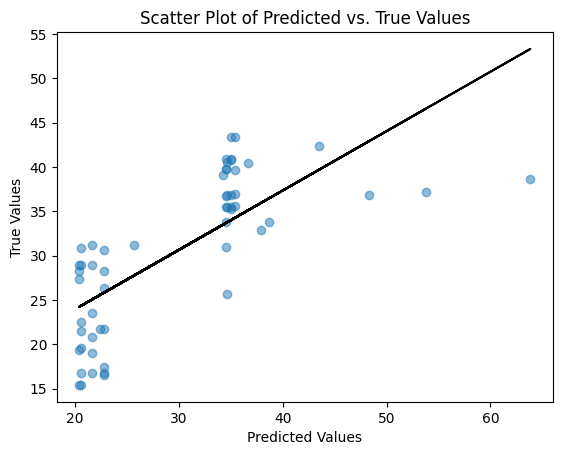

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred_50_10, y_test_50_10, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred_50_10.flatten(), y_test_50_10.flatten(), 1)
plt.plot(y_pred_50_10.flatten(), m*y_pred_50_10.flatten() + b, color='black')

plt.show()


In [75]:
X_train_50_10, X_test_50_10, y_train_50_10, y_test_50_10 = train_test_split(X_50_10, y_50_10, test_size=0.2, random_state=42)

In [76]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_50_10)
X_test_scaled = scaler.transform(X_test_50_10)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train_50_10)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test_50_10)
print("Model score:", score)


[LibSVM]Model score: 0.5331886771093355


In [77]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test_50_10, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_50_10, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_50_10, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_50_10, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.5331886771093355
Mean Absolute Error (MAE): 4.594633300087229
Root Mean Squared Error (RMSE): 5.820990454496484
Mean Absolute Percentage Error (MAPE): 0.19641306455975785


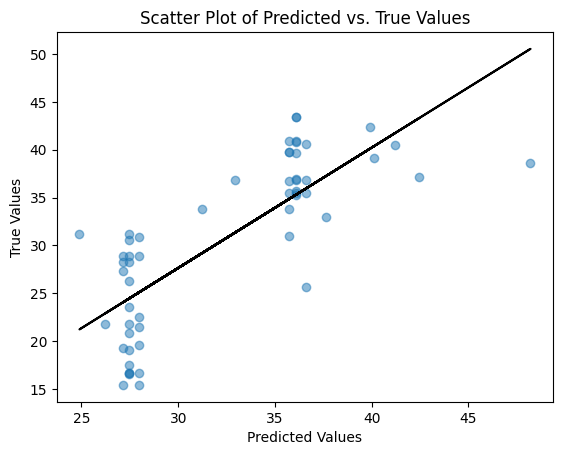

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_50_10, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_50_10, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [79]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_50_10)
X_test_scaled = scaler.transform(X_test_50_10)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train_50_10)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test_50_10, y_pred)
print("Model score:", score)


Model score: 0.6815705717955443


In [80]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test_50_10, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_50_10, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_50_10, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_50_10, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.6815705717955443
Mean Absolute Error (MAE): 4.01299667489082
Root Mean Squared Error (RMSE): 4.8076494635952365
Mean Absolute Percentage Error (MAPE): 0.15597351763331754


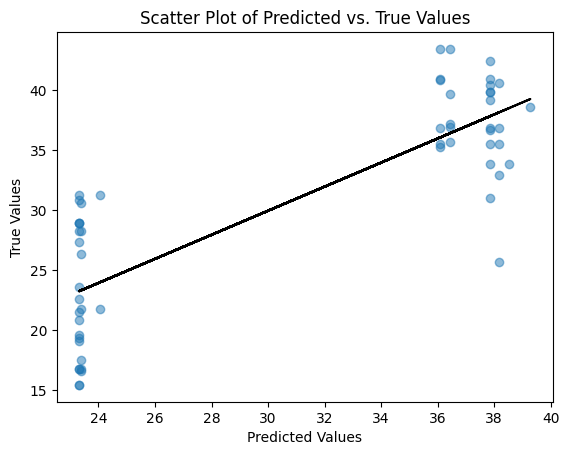

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_50_10, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_50_10, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# 50m only 20x20



In [82]:
df_50m_20 = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_50_20.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df_50m_20

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 1527,Descriptors 1528,Descriptors 1529,Descriptors 1530,Descriptors 1531,Descriptors 1532,Descriptors 1533,Descriptors 1534,Descriptors 1535,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,1,0.0,0.0,0.000000,0.000000,7.414187,6.351375,7.414187,6.351375,7.414187,...,79.0,61.0,36.0,2.0,0.0,0.0,0.0,1.0,26.0,39.15
692,1,0.0,0.0,3.101490,3.184013,3.101490,3.184013,5.646353,15.412680,5.793063,...,77.0,26.0,83.0,47.0,3.0,11.0,20.0,14.0,21.0,39.15
693,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.0,23.0,51.0,19.0,5.0,23.0,25.0,11.0,8.0,39.15
694,1,0.0,0.0,0.000000,0.000000,2.664693,7.052743,7.136914,12.008416,8.484742,...,22.0,18.0,11.0,10.0,33.0,55.0,12.0,1.0,6.0,39.15


In [83]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df_50m_20[df_50m_20['Feature Extraction 0'].isna()]
nan_rows_d = df_50m_20[df_50m_20['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df_50m_20 = df_50m_20.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df_50m_20 = df_50m_20.dropna(subset=['Descriptors 0'])

Found 348 rows with NaN values in the Feature Extraction column.
Found 348 rows with NaN values in the Descriptors column.


In [84]:
X_50m_20 = df_50m_20.drop('Carbon Values', axis=1)
y_50m_20 = df_50m_20['Carbon Values']

In [85]:
X_train_50_20, X_test_50_20, y_train_50_20, y_test_50_20 = train_test_split(X_50m_20, y_50m_20, test_size=0.2, random_state=42)

In [86]:
X_train_50_20 = X_train_50_20.values.reshape((X_train_50_20.shape[0], X_train_50_20.shape[1], 1))
X_test_50_20 = X_test_50_20.values.reshape((X_test_50_20.shape[0], X_test_50_20.shape[1], 1))

y_train_50_20 = y_train_50_20.values
y_test_50_20 = y_test_50_20.values

In [87]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train_50_20, X_test_50_20])

# Flatten the input sequences
X_train_flattened_50_20 = np.array([x.flatten() for x in X_train_50_20])
X_test_flattened_50_20 = np.array([x.flatten() for x in X_test_50_20])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized_50_20 = scaler.fit_transform(X_train_flattened_50_20)
X_test_normalized_50_20 = scaler.transform(X_test_flattened_50_20)

# Reshape the paddedsequences to match the input shape expected by the model
X_train_padded_50_20 = np.expand_dims(X_train_normalized_50_20, axis=-1)
X_test_padded_50_20 = np.expand_dims(X_test_normalized_50_20, axis=-1)


In [88]:
from keras.models import Model
from keras.layers import Flatten,Input,InputLayer, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None,1))


x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=512, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1,activation='relu')(x)

model_50_20 = Model(inputs=inputs, outputs=outputs)


In [89]:
model_50_20.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

In [90]:
hist_50_20 = model_50_20.fit(X_train_padded_50_20,
                          y_train_50_20,
                          epochs= 300,
                          batch_size=64,
                          verbose = 1,
                          callbacks=[reduce_lr, early_stop],
                          validation_data=(X_test_padded_50_20,
                          y_test_50_20))

Epoch 1/300
5/5 [==============================] - 3s 120ms/step - loss: 90.0434 - val_loss: 97.0611 - lr: 0.0010
Epoch 2/300
5/5 [==============================] - 0s 27ms/step - loss: 50.7668 - val_loss: 96.7754 - lr: 0.0010
Epoch 3/300
5/5 [==============================] - 0s 26ms/step - loss: 47.4352 - val_loss: 96.8587 - lr: 0.0010
Epoch 4/300
5/5 [==============================] - 0s 25ms/step - loss: 44.9870 - val_loss: 97.0284 - lr: 0.0010
Epoch 5/300
5/5 [==============================] - 0s 26ms/step - loss: 40.9327 - val_loss: 97.0113 - lr: 0.0010
Epoch 6/300
5/5 [==============================] - 0s 25ms/step - loss: 35.9760 - val_loss: 97.0122 - lr: 0.0010
Epoch 7/300
5/5 [==============================] - 0s 30ms/step - loss: 40.9171 - val_loss: 97.0557 - lr: 0.0010
Epoch 8/300
5/5 [==============================] - 0s 26ms/step - loss: 41.2566 - val_loss: 97.0458 - lr: 0.0010
Epoch 9/300
5/5 [==============================] - 0s 26ms/step - loss: 38.5662 - val_loss: 97.

In [91]:
y_pred_50_20 = model_50_20.predict(X_test_padded_50_20)
mape = mean_absolute_percentage_error(y_test_50_20, y_pred_50_20)
print(f'MAPE: {mape}')

3/3 [==============================] - 0s 7ms/step
MAPE: 0.9527378253983654


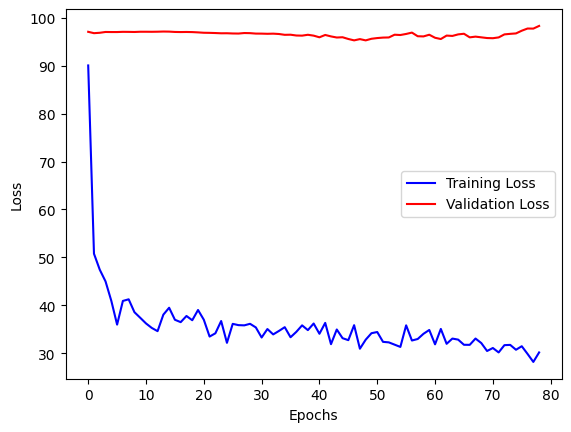

In [92]:
import matplotlib.pyplot as plt


plt.plot(hist_50_20.history['loss'], label='Training Loss', color='blue')
plt.plot(hist_50_20.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [93]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test_50_20, y_pred_50_20)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_50_20, y_pred_50_20)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_50_20, y_pred_50_20, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared score on test set: -32.88518740339299
Mean Absolute Error (MAE): 29.202835882459365
Root Mean Squared Error (RMSE): 51.15860374307243


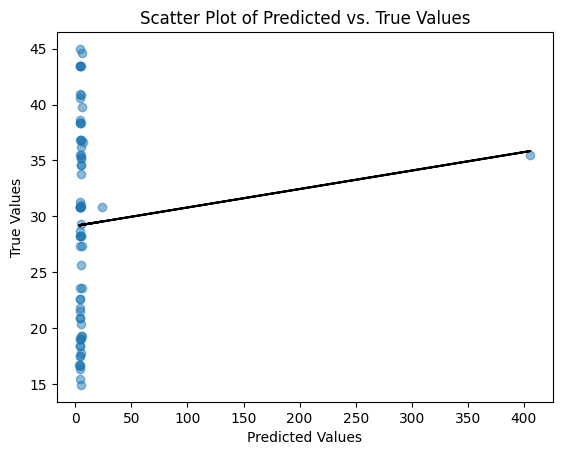

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred_50_20, y_test_50_20, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred_50_20.flatten(), y_test_50_20.flatten(), 1)
plt.plot(y_pred_50_20.flatten(), m*y_pred_50_20.flatten() + b, color='black')

plt.show()


In [95]:
X_train_50_20, X_test_50_20, y_train_50_20, y_test_50_20 = train_test_split(X_50m_20, y_50m_20, test_size=0.2, random_state=42)

In [96]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_50_20)
X_test_scaled = scaler.transform(X_test_50_20)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train_50_20)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test_50_20)
print("Model score:", score)


[LibSVM]Model score: 0.6463090610364695


In [97]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test_50_20, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_50_20, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_50_20, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_50_20, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.6463090610364695
Mean Absolute Error (MAE): 4.477476016559369
Root Mean Squared Error (RMSE): 5.226677501917095
Mean Absolute Percentage Error (MAPE): 0.1756480129282214


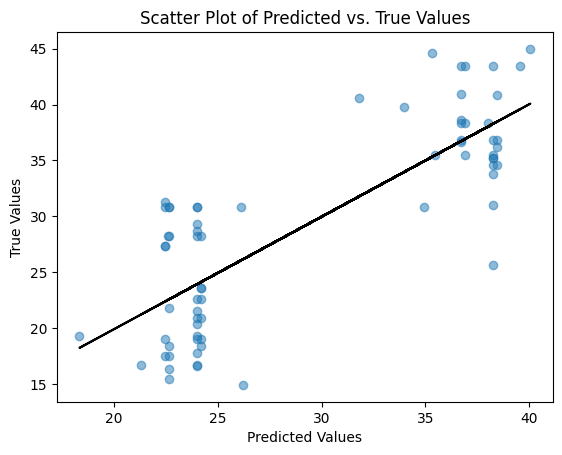

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_50_20, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_50_20, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [99]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_50_20)
X_test_scaled = scaler.transform(X_test_50_20)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train_50_20)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test_50_20, y_pred)
print("Model score:", score)


Model score: 0.6767236446936582


In [100]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test_50_20, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_50_20, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_50_20, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_50_20, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.6767236446936582
Mean Absolute Error (MAE): 4.242721208188952
Root Mean Squared Error (RMSE): 4.996900566923517
Mean Absolute Percentage Error (MAPE): 0.16645166107383144


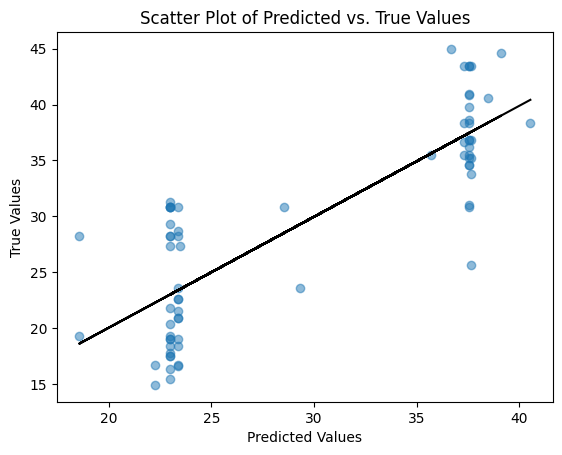

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_50_20, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_50_20, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# 50m only 30x30



In [102]:
df_50m_30 = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_50_30.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df_50m_30

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 1527,Descriptors 1528,Descriptors 1529,Descriptors 1530,Descriptors 1531,Descriptors 1532,Descriptors 1533,Descriptors 1534,Descriptors 1535,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.0,23.0,51.0,19.0,5.0,23.0,25.0,11.0,8.0,39.15
696,1,0.0,0.0,0.000000,0.000000,2.664693,7.052743,7.136914,12.008416,8.484742,...,22.0,18.0,11.0,10.0,33.0,55.0,12.0,1.0,6.0,39.15
697,1,0.0,0.0,5.087558,6.162701,7.037967,11.285603,7.037967,11.285603,8.623734,...,29.0,28.0,4.0,3.0,28.0,71.0,127.0,45.0,13.0,39.15
698,2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,101.0,2.0,0.0,0.0,0.0,0.0,5.0,13.0,5.0,41.22


In [103]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df_50m_30[df_50m_30['Feature Extraction 0'].isna()]
nan_rows_d = df_50m_30[df_50m_30['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df_50m_30 = df_50m_30.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df_50m_30 = df_50m_30.dropna(subset=['Descriptors 0'])

Found 350 rows with NaN values in the Feature Extraction column.
Found 350 rows with NaN values in the Descriptors column.


In [104]:
X_50m_30 = df_50m_30.drop('Carbon Values', axis=1)
y_50m_30 = df_50m_30['Carbon Values']

In [105]:
X_train_50_30, X_test_50_30, y_train_50_30, y_test_50_30 = train_test_split(X_50m_30, y_50m_30, test_size=0.2, random_state=42)

In [106]:
X_train_50_30 = X_train_50_30.values.reshape((X_train_50_30.shape[0], X_train_50_30.shape[1], 1))
X_test_50_30 = X_test_50_30.values.reshape((X_test_50_30.shape[0], X_test_50_30.shape[1], 1))

y_train_50_30 = y_train_50_30.values
y_test_50_30 = y_test_50_30.values

In [107]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train_50_30, X_test_50_30])

# Flatten the input sequences
X_train_flattened_50_30 = np.array([x.flatten() for x in X_train_50_30])
X_test_flattened_50_30 = np.array([x.flatten() for x in X_test_50_30])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized_50_30 = scaler.fit_transform(X_train_flattened_50_30)
X_test_normalized_50_30 = scaler.transform(X_test_flattened_50_30)


# Reshape the paddedsequences to match the input shape expected by the model
X_train_padded_50_30 = np.expand_dims(X_train_normalized_50_30, axis=-1)
X_test_padded_50_30 = np.expand_dims(X_test_normalized_50_30, axis=-1)


In [108]:
from keras.models import Model
from keras.layers import Flatten,Input,InputLayer, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D


x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(filters=512, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1,activation='relu')(x)

model_50_30 = Model(inputs=inputs, outputs=outputs)


In [109]:
model_50_30.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

In [110]:
hist_50_30 = model_50_30.fit(X_train_padded_50_30, y_train_50_30,
                             epochs= 300,
                             batch_size=64,
                             verbose = 1,
                             callbacks=[reduce_lr, early_stop],
                             validation_data=(X_test_padded_50_30, y_test_50_30))

Epoch 1/300
5/5 [==============================] - 5s 231ms/step - loss: 72.8980 - val_loss: 92.3554 - lr: 0.0010
Epoch 2/300
5/5 [==============================] - 0s 52ms/step - loss: 46.1861 - val_loss: 89.5597 - lr: 0.0010
Epoch 3/300
5/5 [==============================] - 0s 46ms/step - loss: 42.2756 - val_loss: 92.6583 - lr: 0.0010
Epoch 4/300
5/5 [==============================] - 0s 37ms/step - loss: 42.1779 - val_loss: 92.5092 - lr: 0.0010
Epoch 5/300
5/5 [==============================] - 0s 33ms/step - loss: 36.3828 - val_loss: 90.2521 - lr: 0.0010
Epoch 6/300
5/5 [==============================] - 0s 40ms/step - loss: 43.6417 - val_loss: 89.7754 - lr: 0.0010
Epoch 7/300
5/5 [==============================] - 0s 35ms/step - loss: 42.4835 - val_loss: 91.2267 - lr: 0.0010
Epoch 8/300
5/5 [==============================] - 0s 35ms/step - loss: 36.7610 - val_loss: 90.0640 - lr: 0.0010
Epoch 9/300
5/5 [==============================] - 0s 31ms/step - loss: 37.0858 - val_loss: 90.

In [111]:
y_pred_50_30 = model_50_30.predict(X_test_padded_50_30)
mape = mean_absolute_percentage_error(y_test_50_30, y_pred_50_30)
print(f'MAPE: {mape}')

3/3 [==============================] - 0s 5ms/step
MAPE: 0.3665420014317181


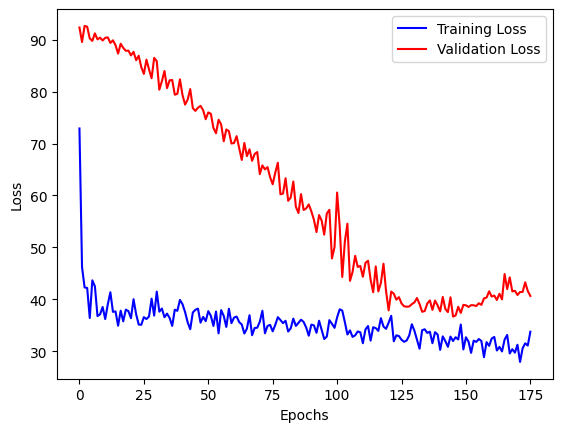

In [112]:
import matplotlib.pyplot as plt


plt.plot(hist_50_30.history['loss'], label='Training Loss', color='blue')
plt.plot(hist_50_30.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test_50_30, y_pred_50_30)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_50_30, y_pred_50_30)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_50_30, y_pred_50_30, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared score on test set: -4.1416774610102385
Mean Absolute Error (MAE): 11.619542653764999
Root Mean Squared Error (RMSE): 19.237074530396708


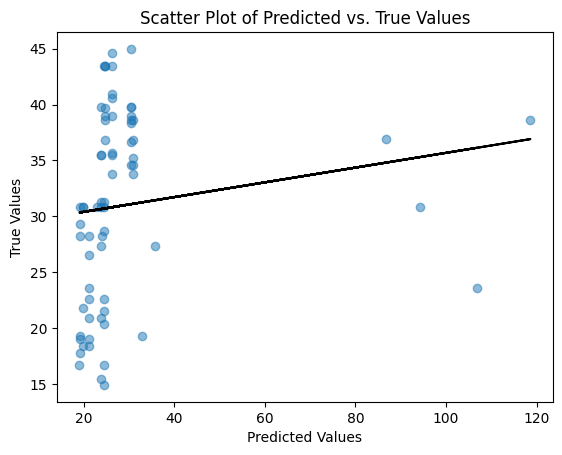

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred_50_30, y_test_50_30, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred_50_30.flatten(), y_test_50_30.flatten(), 1)
plt.plot(y_pred_50_30.flatten(), m*y_pred_50_30.flatten() + b, color='black')

plt.show()


In [115]:
X_train_50_30, X_test_50_30, y_train_50_30, y_test_50_30 = train_test_split(X_50m_30, y_50m_30, test_size=0.2, random_state=42)

In [116]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_50_30)
X_test_scaled = scaler.transform(X_test_50_30)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train_50_30)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test_50_30)
print("Model score:", score)


[LibSVM]Model score: 0.6462524125458098


In [117]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test_50_30, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_50_30, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_50_30, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_50_30, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.6462524125458098
Mean Absolute Error (MAE): 4.054500139224791
Root Mean Squared Error (RMSE): 5.045838615286418
Mean Absolute Percentage Error (MAPE): 0.161625116422792


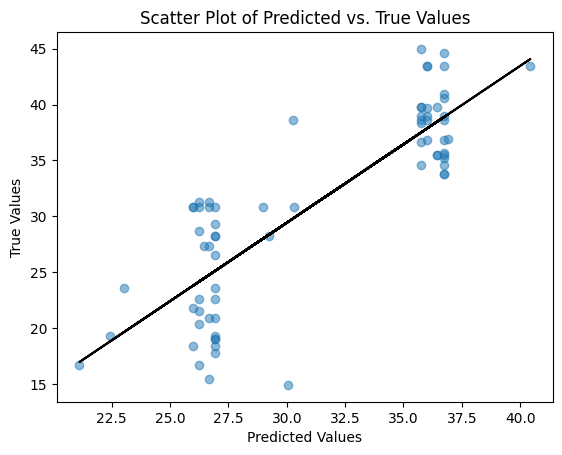

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_50_30, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_50_30, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [119]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_50_30)
X_test_scaled = scaler.transform(X_test_50_30)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train_50_30)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test_50_30, y_pred)
print("Model score:", score)


Model score: 0.6975159661383151


In [120]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test_50_30, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_50_30, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_50_30, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_50_30, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.6975159661383151
Mean Absolute Error (MAE): 3.8657611786733406
Root Mean Squared Error (RMSE): 4.665925935423192
Mean Absolute Percentage Error (MAPE): 0.13884078768451888


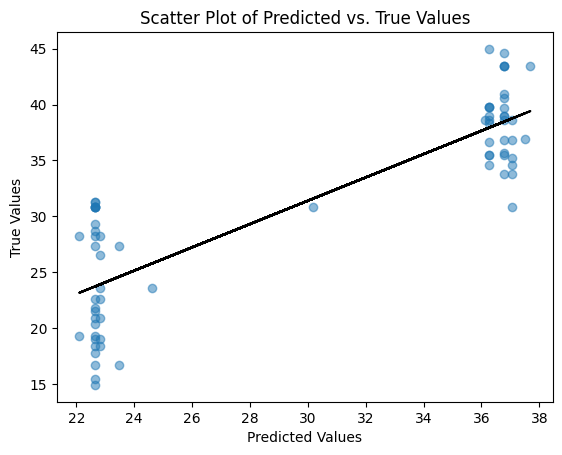

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_50_30, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_50_30, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# 25m only 10x10



In [122]:
df_25m = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_25_10.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df_25m

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Descriptors 0,Descriptors 1,Descriptors 2,...,Descriptors 375,Descriptors 376,Descriptors 377,Descriptors 378,Descriptors 379,Descriptors 380,Descriptors 381,Descriptors 382,Descriptors 383,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.72
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.72
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,2,0.0,0.0,3.273748,3.939366,3.273748,3.939366,0.0,0.0,0.0,...,19.0,3.0,5.0,13.0,15.0,17.0,7.0,14.0,17.0,44.08
312,2,0.0,0.0,0.000000,0.000000,4.945396,6.846520,0.0,0.0,0.0,...,3.0,20.0,40.0,66.0,51.0,11.0,3.0,3.0,14.0,36.69
313,2,0.0,0.0,3.827293,4.292791,3.827293,4.292791,0.0,0.0,0.0,...,6.0,1.0,2.0,13.0,10.0,2.0,1.0,0.0,0.0,39.54
314,2,0.0,0.0,7.004043,4.342918,7.004043,4.342918,0.0,0.0,0.0,...,86.0,1.0,0.0,0.0,0.0,7.0,3.0,0.0,2.0,39.15


In [123]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df_25m[df_25m['Feature Extraction 0'].isna()]
nan_rows_d = df_25m[df_25m['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df_25m = df_25m.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df_25m = df_25m.dropna(subset=['Descriptors 0'])

Found 158 rows with NaN values in the Feature Extraction column.
Found 158 rows with NaN values in the Descriptors column.


In [124]:
X_25_10 = df_25m.drop('Carbon Values', axis=1)
y_25_10 = df_25m['Carbon Values']

In [125]:
X_train_25_10, X_test_25_10, y_train_25_10, y_test_25_10 = train_test_split(X_25_10, y_25_10, test_size=0.2, random_state=42)

In [126]:
X_train_25_10 = X_train_25_10.values.reshape((X_train_25_10.shape[0], X_train_25_10.shape[1], 1))
X_test_25_10 = X_test_25_10.values.reshape((X_test_25_10.shape[0], X_test_25_10.shape[1], 1))

y_train_25_10 = y_train_25_10.values
y_test_25_10 = y_test_25_10.values

In [127]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train_25_10, X_test_25_10])

# Flatten the input sequences
X_train_flattened_25_10 = np.array([x.flatten() for x in X_train_25_10])
X_test_flattened_25_10 = np.array([x.flatten() for x in X_test_25_10])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized_25_10 = scaler.fit_transform(X_train_flattened_25_10)
X_test_normalized_25_10 = scaler.transform(X_test_flattened_25_10)

# Reshape the paddedsequences to match the input shape expected by the model
X_train_padded_25_10 = np.expand_dims(X_train_normalized_25_10, axis=-1)
X_test_padded_25_10 = np.expand_dims(X_test_normalized_25_10, axis=-1)


In [128]:
from keras.models import Model
from keras.layers import Flatten,Input,InputLayer, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


x = Conv1D(filters=512, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1,activation='relu')(x)

model_25_10 = Model(inputs=inputs, outputs=outputs)


In [129]:
model_25_10.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

In [130]:
hist_25_10 = model_25_10.fit(X_train_padded_25_10, y_train_25_10,
                             epochs= 300,
                             batch_size=64,
                             verbose = 1,
                             callbacks=[reduce_lr, early_stop],
                             validation_data=(X_test_padded_25_10, y_test_25_10))

Epoch 1/300
2/2 [==============================] - 3s 523ms/step - loss: 91.4399 - val_loss: 97.6138 - lr: 0.0010
Epoch 2/300
2/2 [==============================] - 0s 38ms/step - loss: 60.3780 - val_loss: 94.3946 - lr: 0.0010
Epoch 3/300
2/2 [==============================] - 0s 40ms/step - loss: 35.9134 - val_loss: 89.8987 - lr: 0.0010
Epoch 4/300
2/2 [==============================] - 0s 38ms/step - loss: 43.0551 - val_loss: 89.2370 - lr: 0.0010
Epoch 5/300
2/2 [==============================] - 0s 38ms/step - loss: 40.2215 - val_loss: 91.1129 - lr: 0.0010
Epoch 6/300
2/2 [==============================] - 0s 46ms/step - loss: 28.4684 - val_loss: 93.1279 - lr: 0.0010
Epoch 7/300
2/2 [==============================] - 0s 35ms/step - loss: 29.5585 - val_loss: 93.9954 - lr: 0.0010
Epoch 8/300
2/2 [==============================] - 0s 34ms/step - loss: 34.2430 - val_loss: 93.8651 - lr: 0.0010
Epoch 9/300
2/2 [==============================] - 0s 34ms/step - loss: 29.6062 - val_loss: 92.

In [131]:
y_pred_25_10 = model_25_10.predict(X_test_padded_25_10)
mape = mean_absolute_percentage_error(y_test_25_10, y_pred_25_10)
print(f'MAPE: {mape}')

1/1 [==============================] - 0s 156ms/step
MAPE: 0.8923703532785054


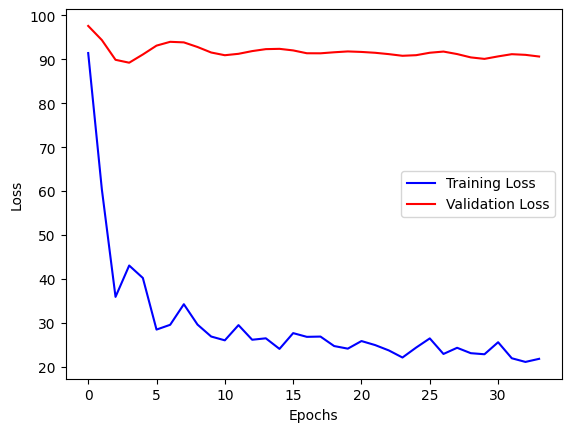

In [132]:
import matplotlib.pyplot as plt


plt.plot(hist_25_10.history['loss'], label='Training Loss', color='blue')
plt.plot(hist_25_10.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [133]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test_25_10, y_pred_25_10)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_25_10, y_pred_25_10)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_25_10, y_pred_25_10, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared score on test set: -21.293260685623707
Mean Absolute Error (MAE): 31.97149441629648
Root Mean Squared Error (RMSE): 32.91245472533666


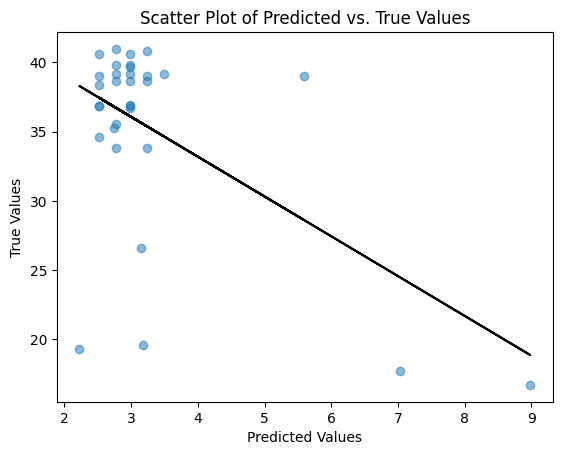

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred_25_10, y_test_25_10, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred_25_10.flatten(), y_test_25_10.flatten(), 1)
plt.plot(y_pred_25_10.flatten(), m*y_pred_25_10.flatten() + b, color='black')

plt.show()



In [135]:
X_train_25_10, X_test_25_10, y_train_25_10, y_test_25_10 = train_test_split(X_25_10, y_25_10, test_size=0.2, random_state=42)

In [136]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_25_10)
X_test_scaled = scaler.transform(X_test_25_10)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train_25_10)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test_25_10)
print("Model score:", score)


[LibSVM]Model score: 0.2955716856556472


In [137]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test_25_10, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_25_10, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_25_10, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_25_10, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.2955716856556472
Mean Absolute Error (MAE): 3.926170678208157
Root Mean Squared Error (RMSE): 5.850485124899393
Mean Absolute Percentage Error (MAPE): 0.15224960359457365


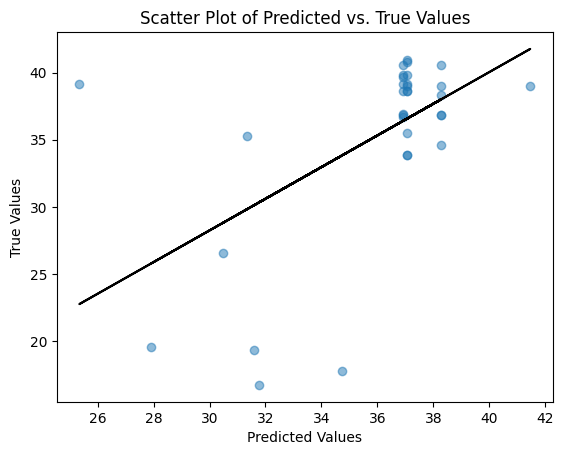

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_25_10, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_25_10, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [139]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_25_10)
X_test_scaled = scaler.transform(X_test_25_10)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train_25_10)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test_25_10, y_pred)
print("Model score:", score)


Model score: 0.7550475872972371


In [140]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test_25_10, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_25_10, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_25_10, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_25_10, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.7550475872972371
Mean Absolute Error (MAE): 2.5446845216745237
Root Mean Squared Error (RMSE): 3.4499622119930287
Mean Absolute Percentage Error (MAPE): 0.0840553380596536


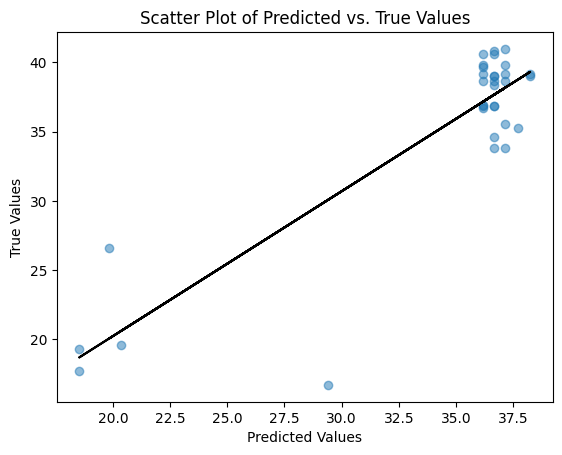

In [141]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_25_10, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_25_10, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# 25m only 20x20



In [142]:
df_25m_20 = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_25_20.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df_25m_20

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 1399,Descriptors 1400,Descriptors 1401,Descriptors 1402,Descriptors 1403,Descriptors 1404,Descriptors 1405,Descriptors 1406,Descriptors 1407,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.72
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.72
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.72
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.91
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,39.0,25.0,9.0,16.0,45.0,10.0,0.0,2.0,43.82
636,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,4.0,39.54
637,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,101.0,29.0,5.0,2.0,15.0,32.0,6.0,17.0,39.15
638,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,96.0,6.0,3.0,15.0,79.0,131.0,16.0,5.0,8.0,39.15


In [143]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df_25m_20[df_25m_20['Feature Extraction 0'].isna()]
nan_rows_d = df_25m_20[df_25m_20['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df_25m_20 = df_25m_20.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df_25m_20 = df_25m_20.dropna(subset=['Descriptors 0'])

Found 320 rows with NaN values in the Feature Extraction column.
Found 320 rows with NaN values in the Descriptors column.


In [144]:
X_25m_20 = df_25m_20.drop('Carbon Values', axis=1)
y_25m_20 = df_25m_20['Carbon Values']

In [145]:
X_train_25_20, X_test_25_20, y_train_25_20, y_test_25_20 = train_test_split(X_25m_20, y_25m_20, test_size=0.2, random_state=42)

In [146]:
X_train_25_20 = X_train_25_20.values.reshape((X_train_25_20.shape[0], X_train_25_20.shape[1], 1))
X_test_25_20 = X_test_25_20.values.reshape((X_test_25_20.shape[0], X_test_25_20.shape[1], 1))

y_train_25_20 = y_train_25_20.values
y_test_25_20 = y_test_25_20.values

In [147]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train_25_20, X_test_25_20])

# Flatten the input sequences
X_train_flattened_25_20 = np.array([x.flatten() for x in X_train_25_20])
X_test_flattened_25_20 = np.array([x.flatten() for x in X_test_25_20])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized_25_20 = scaler.fit_transform(X_train_flattened_25_20)
X_test_normalized_25_20 = scaler.transform(X_test_flattened_25_20)

# Reshape the paddedsequences to match the input shape expected by the model
X_train_padded_25_20 = np.expand_dims(X_train_normalized_25_20, axis=-1)
X_test_padded_25_20 = np.expand_dims(X_test_normalized_25_20, axis=-1)


In [148]:
from keras.models import Model
from keras.layers import Flatten,Input,InputLayer, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


x = Conv1D(filters=512, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1,activation='relu')(x)

model_25_20 = Model(inputs=inputs, outputs=outputs)


In [149]:
model_25_20.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

In [150]:
hist_25_20 = model_25_20.fit(X_train_padded_25_20,
                             y_train_25_20,
                             epochs= 300,
                             batch_size=64,
                             verbose = 1,
                             callbacks=[reduce_lr, early_stop],
                             validation_data=(X_test_padded_25_20, y_test_25_20))

Epoch 1/300
4/4 [==============================] - 2s 89ms/step - loss: 73.7342 - val_loss: 94.5086 - lr: 0.0010
Epoch 2/300
4/4 [==============================] - 0s 39ms/step - loss: 39.9913 - val_loss: 90.6110 - lr: 0.0010
Epoch 3/300
4/4 [==============================] - 0s 38ms/step - loss: 33.1761 - val_loss: 93.7080 - lr: 0.0010
Epoch 4/300
4/4 [==============================] - 0s 38ms/step - loss: 31.2190 - val_loss: 94.3850 - lr: 0.0010
Epoch 5/300
4/4 [==============================] - 0s 34ms/step - loss: 30.6882 - val_loss: 92.4844 - lr: 0.0010
Epoch 6/300
4/4 [==============================] - 0s 39ms/step - loss: 30.0564 - val_loss: 92.0875 - lr: 0.0010
Epoch 7/300
4/4 [==============================] - 0s 37ms/step - loss: 30.2319 - val_loss: 93.2189 - lr: 0.0010
Epoch 8/300
4/4 [==============================] - 0s 34ms/step - loss: 27.8058 - val_loss: 92.8699 - lr: 0.0010
Epoch 9/300
4/4 [==============================] - 0s 39ms/step - loss: 24.7962 - val_loss: 91.7

In [151]:
y_pred_25_20 = model_25_20.predict(X_test_padded_25_20)
mape = mean_absolute_percentage_error(y_test_25_20, y_pred_25_20)
print(f'MAPE: {mape}')

2/2 [==============================] - 0s 7ms/step
MAPE: 0.26980187280307866


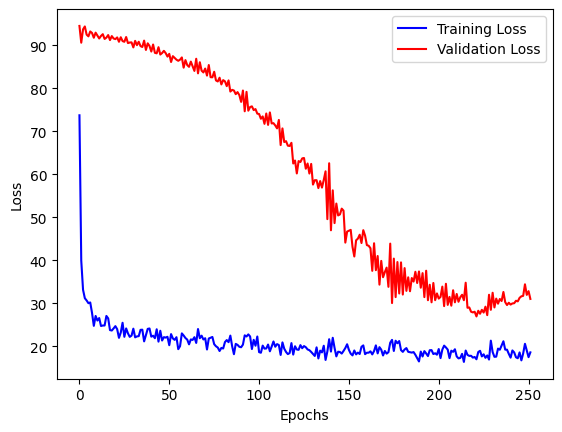

In [152]:
import matplotlib.pyplot as plt


plt.plot(hist_25_20.history['loss'], label='Training Loss', color='blue')
plt.plot(hist_25_20.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [153]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test_25_20, y_pred_25_20)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_25_20, y_pred_25_20)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_25_20, y_pred_25_20, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared score on test set: -6.233510979563028
Mean Absolute Error (MAE): 9.000094933509827
Root Mean Squared Error (RMSE): 19.066014552632307


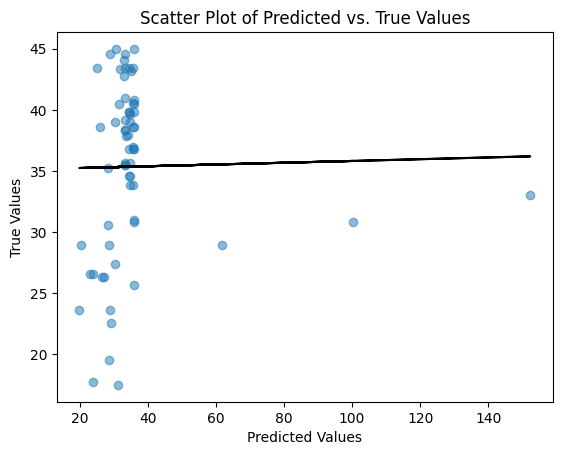

In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred_25_20, y_test_25_20, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred_25_20.flatten(), y_test_25_20.flatten(), 1)
plt.plot(y_pred_25_20.flatten(), m*y_pred_25_20.flatten() + b, color='black')

plt.show()


In [155]:
X_train_25_20, X_test_25_20, y_train_25_20, y_test_25_20 = train_test_split(X_25m_20, y_25m_20, test_size=0.2, random_state=42)

In [156]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_25_20)
X_test_scaled = scaler.transform(X_test_25_20)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train_25_20)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test_25_20)
print("Model score:", score)


[LibSVM]Model score: 0.39488972454061055


In [157]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test_25_20, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_25_20, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_25_20, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_25_20, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.39488972454061055
Mean Absolute Error (MAE): 4.013912443667289
Root Mean Squared Error (RMSE): 5.5144551841977085
Mean Absolute Percentage Error (MAPE): 0.12487676770636406


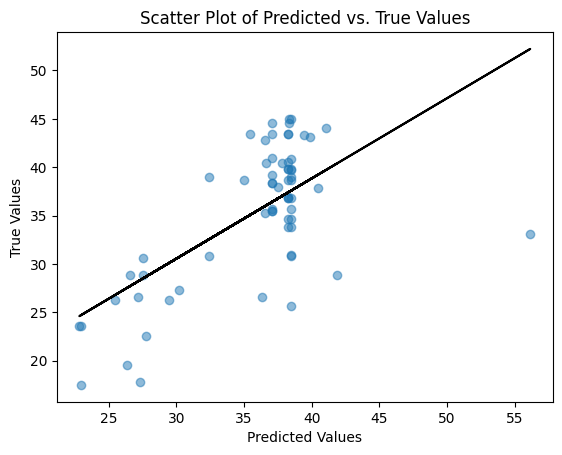

In [158]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_25_20, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_25_20, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [159]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_25_20)
X_test_scaled = scaler.transform(X_test_25_20)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train_25_20)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test_25_20, y_pred)
print("Model score:", score)


Model score: 0.5778959867086692


In [160]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test_25_20, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_25_20, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_25_20, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_25_20, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.5778959867086692
Mean Absolute Error (MAE): 3.5846786806709705
Root Mean Squared Error (RMSE): 4.605694085655308
Mean Absolute Percentage Error (MAPE): 0.10873603525475789


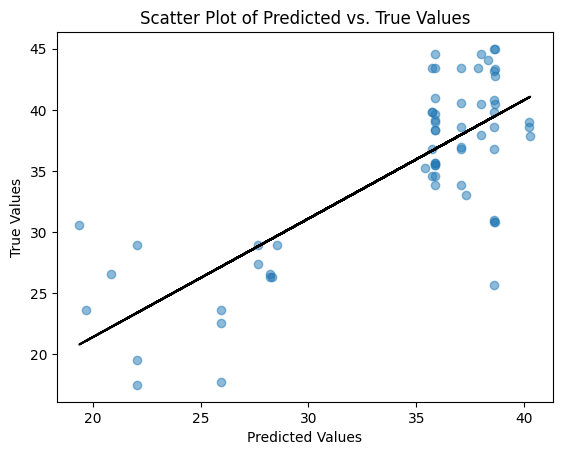

In [161]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_25_20, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_25_20, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


# 25m only 30x30



In [162]:
df_25m_30 = pd.read_csv('/content/drive/MyDrive/sift only/dataframe_sift_25_30.csv',
                 converters={'Carbon Values': lambda x: float(x.replace(',', '.'))})

# df = df.drop(columns=['Unnamed: 0'],axis=1 )

df_25m_30

,HST,Feature Extraction 0,Feature Extraction 1,Feature Extraction 2,Feature Extraction 3,Feature Extraction 4,Feature Extraction 5,Feature Extraction 6,Feature Extraction 7,Feature Extraction 8,...,Descriptors 5495,Descriptors 5496,Descriptors 5497,Descriptors 5498,Descriptors 5499,Descriptors 5500,Descriptors 5501,Descriptors 5502,Descriptors 5503,Carbon Values
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,8.0,2.0,1.0,4.0,22.0,6.0,2.0,3.0,39.15
986,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,9.0,3.0,0.0,9.0,73.0,4.0,0.0,1.0,39.15
987,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,47.0,79.0,23.0,10.0,3.0,13.0,22.0,23.0,37.46
988,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.22


In [163]:
# Check for NaN values in the 'Feature Extraction' and 'Descriptors' columns
nan_rows_fe = df_25m_30[df_25m_30['Feature Extraction 0'].isna()]
nan_rows_d = df_25m_30[df_25m_30['Descriptors 0'].isna()]

if not nan_rows_fe.empty:
    print(f'Found {len(nan_rows_fe)} rows with NaN values in the Feature Extraction column.')
    df_25m_30 = df_25m_30.dropna(subset=['Feature Extraction 0'])

if not nan_rows_d.empty:
    print(f'Found {len(nan_rows_d)} rows with NaN values in the Descriptors column.')
    df_25m_30 = df_25m_30.dropna(subset=['Descriptors 0'])

Found 495 rows with NaN values in the Feature Extraction column.
Found 495 rows with NaN values in the Descriptors column.


In [164]:
X_25m_30 = df_25m_30.drop('Carbon Values', axis=1)
y_25m_30 = df_25m_30['Carbon Values']

In [165]:
X_train_25_30, X_test_25_30, y_train_25_30, y_test_25_30 = train_test_split(X_25m_30, y_25m_30, test_size=0.2, random_state=42)

In [166]:
X_train_25_30 = X_train_25_30.values.reshape((X_train_25_30.shape[0], X_train_25_30.shape[1], 1))
X_test_25_30 = X_test_25_30.values.reshape((X_test_25_30.shape[0], X_test_25_30.shape[1], 1))

y_train_25_30 = y_train_25_30.values
y_test_25_30 = y_test_25_30.values

In [167]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler,MaxAbsScaler

# Concatenate training and testing sequences to find the maximum sequence length
all_sequences = np.concatenate([X_train_25_30, X_test_25_30])

# Flatten the input sequences
X_train_flattened_25_30 = np.array([x.flatten() for x in X_train_25_30])
X_test_flattened_25_30 = np.array([x.flatten() for x in X_test_25_30])

# Normalize the flattened sequences
scaler = MaxAbsScaler()
# scaler = StandardScaler()
X_train_normalized_25_30 = scaler.fit_transform(X_train_flattened_25_30)
X_test_normalized_25_30 = scaler.transform(X_test_flattened_25_30)

X_train_padded_25_30 = np.expand_dims(X_train_normalized_25_30 , axis=-1)
X_test_padded_25_30 = np.expand_dims(X_test_normalized_25_30 , axis=-1)


In [168]:
from keras.models import Model
from keras.layers import Flatten,Input,InputLayer, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, BatchNormalization,GlobalMaxPooling1D

inputs = Input(shape=(None, 1))

x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)


x = Conv1D(filters=512, kernel_size=3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(512, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1,activation='relu')(x)

model_25_30 = Model(inputs=inputs, outputs=outputs)


In [169]:
model_25_30.compile(optimizer='Adam', loss='mean_absolute_percentage_error')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.1,
                                                     patience=30,
                                                     min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=30,
                                              verbose=1,
                                              restore_best_weights=True)

In [170]:
hist_25_30 = model_25_30.fit(X_train_padded_25_30, y_train_25_30,
                             epochs= 300,
                             batch_size=64,
                             verbose = 1,
                             callbacks=[reduce_lr,early_stop],
                             validation_data=(X_test_padded_25_30, y_test_25_30))

Epoch 1/300
7/7 [==============================] - 5s 302ms/step - loss: 60.6810 - val_loss: 94.9352 - lr: 0.0010
Epoch 2/300
7/7 [==============================] - 1s 97ms/step - loss: 34.4243 - val_loss: 96.3905 - lr: 0.0010
Epoch 3/300
7/7 [==============================] - 1s 98ms/step - loss: 36.0797 - val_loss: 95.3885 - lr: 0.0010
Epoch 4/300
7/7 [==============================] - 1s 96ms/step - loss: 32.3415 - val_loss: 95.8191 - lr: 0.0010
Epoch 5/300
7/7 [==============================] - 1s 93ms/step - loss: 33.5995 - val_loss: 95.3373 - lr: 0.0010
Epoch 6/300
7/7 [==============================] - 1s 91ms/step - loss: 32.4786 - val_loss: 95.6710 - lr: 0.0010
Epoch 7/300
7/7 [==============================] - 1s 94ms/step - loss: 33.0021 - val_loss: 95.2184 - lr: 0.0010
Epoch 8/300
7/7 [==============================] - 1s 95ms/step - loss: 30.3579 - val_loss: 95.2335 - lr: 0.0010
Epoch 9/300
7/7 [==============================] - 1s 94ms/step - loss: 31.8120 - val_loss: 94.

In [171]:
y_pred_25_30 = model_25_30.predict(X_test_padded_25_30)
mape = mean_absolute_percentage_error(y_test_25_30, y_pred_25_30)
print(f'MAPE: {mape}')

4/4 [==============================] - 0s 42ms/step
MAPE: 0.6147571354181262


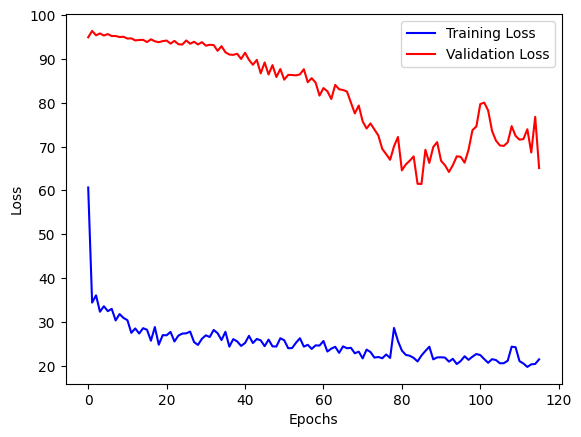

In [172]:
import matplotlib.pyplot as plt


plt.plot(hist_25_30.history['loss'], label='Training Loss', color='blue')
plt.plot(hist_25_30.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [173]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

r2_test = r2_score(y_test_25_30, y_pred_25_30)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_25_30, y_pred_25_30)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_25_30, y_pred_25_30, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

R-squared score on test set: -70.11243138382319
Mean Absolute Error (MAE): 21.706717909995955
Root Mean Squared Error (RMSE): 78.84246782196954


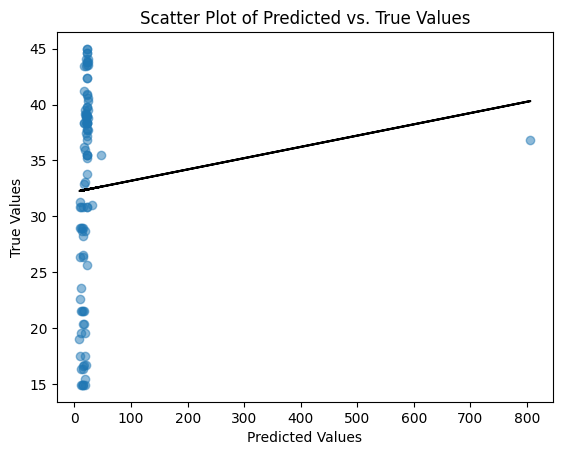

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred_25_30, y_test_25_30, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred_25_30.flatten(), y_test_25_30.flatten(), 1)
plt.plot(y_pred_25_30.flatten(), m*y_pred_25_30.flatten() + b, color='black')

plt.show()


In [175]:
X_train_25_30, X_test_25_30, y_train_25_30, y_test_25_30 = train_test_split(X_25m_30, y_25m_30, test_size=0.2, random_state=42)

In [176]:
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_25_30)
X_test_scaled = scaler.transform(X_test_25_30)

# Create SVR model with a linear kernel
model_svr = SVR(kernel="linear", verbose=3)

# Train the model_svr
model_svr.fit(X_train_scaled, y_train_25_30)

# Evaluate the model_svr
score = model_svr.score(X_test_scaled, y_test_25_30)
print("Model score:", score)


[LibSVM]Model score: 0.561352887122816


In [177]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_svr.predict(X_test_scaled)
r2_test = r2_score(y_test_25_30, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_25_30, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_25_30, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_25_30, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)


R-squared score on test set: 0.561352887122816
Mean Absolute Error (MAE): 5.116906696201828
Root Mean Squared Error (RMSE): 6.192201543173544
Mean Absolute Percentage Error (MAPE): 0.19512621397132804


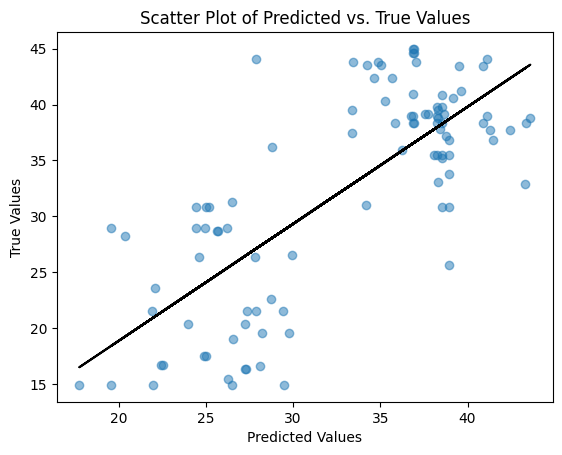

In [178]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_25_30, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_25_30, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [179]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score

# Preprocess the data
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_25_30)
X_test_scaled = scaler.transform(X_test_25_30)

# Create AdaBoostRegressor model
model_adaboost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, loss='linear')

# Train the model_adaboost
model_adaboost.fit(X_train_scaled, y_train_25_30)

# Predict on the test set
y_pred = model_adaboost.predict(X_test_scaled)

# Evaluate the model
score = r2_score(y_test_25_30, y_pred)
print("Model score:", score)


Model score: 0.6829161760549936


In [180]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Assuming you have already trained your model and made predictions on the test set
# If not, replace y_pred with the predictions made by your model
# Compute R-squared score on the test set

y_pred = model_adaboost.predict(X_test_scaled)
r2_test = r2_score(y_test_25_30, y_pred)

print("R-squared score on test set:", r2_test)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_25_30, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Compute Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test_25_30, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

mape = mean_absolute_percentage_error(y_test_25_30, y_pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

R-squared score on test set: 0.6829161760549936
Mean Absolute Error (MAE): 4.25143190993927
Root Mean Squared Error (RMSE): 5.264710431180727
Mean Absolute Percentage Error (MAPE): 0.1651815587559666


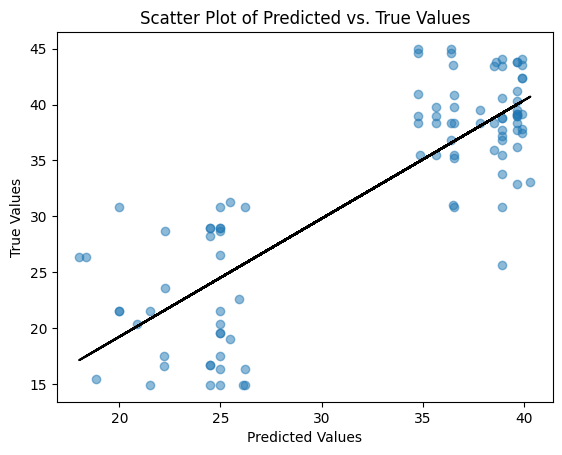

In [181]:
import matplotlib.pyplot as plt
import numpy as np

# Create scatter plot
plt.scatter(y_pred, y_test_25_30, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Scatter Plot of Predicted vs. True Values')

# Calculate the trend line (line of best fit)
m, b = np.polyfit(y_pred, y_test_25_30, 1)
plt.plot(y_pred.flatten(), m*y_pred.flatten() + b, color='black')

plt.show()


In [182]:
model_25_30.save('/content/drive/MyDrive/Skripsi/model/model_25_30.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
